In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import ipywidgets as widgets
from IPython.display import display
import glob
from datetime import datetime,timedelta

In [5]:
!pip install tqdm


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [8]:
#defining the file paths
locs = {'waiting_folder' : '../data/waiting times'}

In [9]:
waiting_times = list()
for attraction in tqdm(os.listdir(locs['waiting_folder'])):
    filename = os.path.join(locs['waiting_folder'], attraction)
    df = pd.read_csv(filename)
    if df.empty:
        continue
    df.insert(0, 'attraction', attraction.split('.')[0])
    waiting_times.append(df)

df_wait_raw = pd.concat(waiting_times, ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data/waiting times'

In [10]:
# data cleaning

In [5]:
df_wait = df_wait_raw.copy()
# Cleaning the actual waiting times
# Removing outliers from actuals
df_wait = df_wait[((df_wait.SACTMIN >= -1000) & (df_wait.SACTMIN < 360)) | (df_wait.SACTMIN.isnull())]
# Removing outliers from posted (attraction closed at -999)
df_wait = df_wait[(df_wait.SPOSTMIN >= -998.99) | (df_wait.SPOSTMIN.isnull())]

df_wait['date'] = pd.to_datetime(df_wait.date, format = '%m/%d/%Y')
df_wait['datetime'] = pd.to_datetime(df_wait.datetime, format = '%Y-%m-%d %H:%M:%S')

print(f"Removed {len(df_wait_raw) - len(df_wait)} rows")

# You could split the dataset into two seperate dataframes (plusjes & minnetjes :-))
df_wait_act = df_wait[~df_wait.SACTMIN.isnull()].drop('SPOSTMIN', axis = 1)
df_wait_post = df_wait[~df_wait.SPOSTMIN.isnull()].drop('SACTMIN', axis = 1)

attractions = df_wait.attraction.unique()

Removed 1318703 rows


In [6]:
# Extract "minutes from df_wait" from the datetime column
df_wait_post['minute'] = df_wait_post['datetime'].dt.hour * 60 + df_wait_post['datetime'].dt.minute

In [7]:
df_wait_post['attraction'].unique()

array(['7_dwarfs_train', 'alien_saucers', 'astro_orbiter', 'barnstormer',
       'big_thunder_mtn', 'buzz_lightyear', 'carousel_of_progress',
       'country_bears', 'dinosaur', 'dumbo', 'enchanted_tiki_rm',
       'expedition_everest', 'flight_of_passage', 'hall_of_presidents',
       'haunted_mansion', 'it_s_a_small_world', 'jungle_cruise',
       'kilimanjaro_safaris', 'laugh_floor', 'liberty_sq_riverboat',
       'mad_tea_party', 'magic_carpets', 'navi_river', 'peoplemover',
       'peter_pan_s_flight', 'philharmagic', 'pirates_of_caribbean',
       'pirate_s_adventure', 'princess_hall__cinderella_elena',
       'princess_hall__rapunzel_tiana', 'regal_carrousel',
       'rock_n_rollercoaster', 'slinky_dog', 'soarin',
       'sorcerers_of_the_mk', 'spaceship_earth', 'space_mountain',
       'splash_mountain', 'swiss_family_tree', 'tom_land_speedway',
       'tom_sawyer_island', 'town_sq_mickey', 'toy_story_mania',
       'under_the_sea', 'winnie_the_pooh'], dtype=object)

In [ ]:
#interpolating and preparing training dataframe

In [7]:

for (date, attraction), group in tqdm(df_wait.groupby(['date', 'attraction'])):
    time_shifted = group['datetime'] - timedelta(hours=3)
    group['minute'] = 3 * 60 + time_shifted.dt.hour * 60 + time_shifted.dt.minute

    if not {'SACTMIN', 'SPOSTMIN'}.issubset(group.columns):
        continue

    # Check if there's enough non-NaN data to interpolate
    if group[['SACTMIN', 'SPOSTMIN']].dropna(how='all').empty:
        continue  # Skip if there's nothing to work with

    group = group.drop(columns=['datetime', 'attraction', 'date'], errors='ignore')
    group = group.groupby('minute', as_index=False)[['SACTMIN', 'SPOSTMIN']].mean()

    new_index = np.arange(0, 27 * 60 + 1, 30)
    group = group.set_index('minute')

    # REINDEX ONLY IF INDEX ISN'T EMPTY
    if group.index.empty:
        continue

    reindexed = group.reindex(np.unique(np.concatenate([new_index, group.index]))).interpolate(method='linear')

    resampled = reindexed.loc[new_index].reset_index()

    for col in ['SACTMIN', 'SPOSTMIN']:
        if col in resampled.columns:
            resampled[col] = ((resampled[col] + 2.5) // 5) * 5

    resampled['SPOSTMIN_interp'] = resampled['SPOSTMIN'].interpolate(method='linear')

    # ⚠️ Avoid dividing by zero or NaN
    if 'SACTMIN' in resampled.columns and 'SPOSTMIN_interp' in resampled.columns:
        resampled['actual_over_posted'] = resampled['SACTMIN'] / resampled['SPOSTMIN_interp']

    resampled.insert(0, 'date', date)
    resampled.insert(1, 'attraction', attraction)

    groups_itp.append(resampled)


NameError: name 'df_wait' is not defined

In [11]:
df_netjes_itp = pd.concat(groups_itp, ignore_index=True)

In [12]:
df_netjes_itp.head()

,date,attraction,minute,SACTMIN,SPOSTMIN,SPOSTMIN_interp,actual_over_posted
0,2015-01-01,7_dwarfs_train,0,NaN,NaN,NaN,NaN
1,2015-01-01,7_dwarfs_train,30,NaN,NaN,NaN,NaN
2,2015-01-01,7_dwarfs_train,60,NaN,NaN,NaN,NaN
3,2015-01-01,7_dwarfs_train,90,NaN,NaN,NaN,NaN
4,2015-01-01,7_dwarfs_train,120,NaN,NaN,NaN,NaN


In [1]:
# Save the full cleaned and interpolated dataset to csv
#df_netjes_itp.to_csv("../data/clean/waiting_times_interpolated.csv")

In [14]:
# Select the dataset for training our prediction model and save it to csv
# Drop unnecessary columns and rows without actual_over_posted ratio
training_dataset = df_netjes_itp.drop(columns=['SACTMIN', 'SPOSTMIN', 'SPOSTMIN_interp']).dropna(subset=['actual_over_posted'])

#training_dataset.to_csv("../data/clean/training_dataset.csv", index=False)

OSError: Cannot save file into a non-existent directory: '../data/clean'

In [13]:
#reading files in the waiting time directory
dfs = []
for filename in glob.glob(os.path.join(path_waiting_times,'*.csv')):
    df = pd.read_csv(filename)
    if df.empty:
        print(f"skipping empty files:{filename}")
        continue
    
    #to extract just the file name without the path
    attraction_name = os.path.basename(filename).replace('.csv','')
    df['attractions'] = attraction_name
    dfs.append(df)

df_waiting_time_data = pd.concat(dfs,ignore_index = True)
df_waiting_time = df_waiting_time_data.copy()
df_waiting_time.head()

skipping empty files:../data/waiting times/ariel_s_grotto.csv
skipping empty files:../data/waiting times/casey_jr_splash.csv
skipping empty files:../data/waiting times/ench_tales_w__belle.csv
skipping empty files:../data/waiting times/main_st_vehicles.csv
skipping empty files:../data/waiting times/pete_s__goofy_donald.csv
skipping empty files:../data/waiting times/pete_s__minnie_daisy.csv
skipping empty files:../data/waiting times/town_sq_tink.csv


,date,datetime,SACTMIN,SPOSTMIN,attractions
0,01/01/2015,2015-01-01 07:51:12,NaN,45.0,7_dwarfs_train
1,01/01/2015,2015-01-01 08:02:13,NaN,60.0,7_dwarfs_train
2,01/01/2015,2015-01-01 08:05:30,54.0,NaN,7_dwarfs_train
3,01/01/2015,2015-01-01 08:09:12,NaN,60.0,7_dwarfs_train
4,01/01/2015,2015-01-01 08:16:12,NaN,60.0,7_dwarfs_train


Step 2 Data Cleaning

#Preprocessing step
Add minute of day.
Split dataframe into actual and posted waiting time.
Remove all -999 as these are waiting times at times that the attraction is closed.


In [16]:
df_waiting_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10306140 entries, 0 to 10306139
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   datetime     object 
 2   SACTMIN      float64
 3   SPOSTMIN     float64
 4   attractions  object 
dtypes: float64(2), object(3)
memory usage: 393.1+ MB


In [17]:
df_waiting_time.isnull().mean()

date           0.000000
datetime       0.000000
SACTMIN        0.981333
SPOSTMIN       0.018667
attractions    0.000000
dtype: float64

In [18]:
  #filling null value with mean value
df_waiting_time['SACTMIN'] = df_waiting_time['SACTMIN'].fillna(df_waiting_time['SACTMIN'].mean())
df_waiting_time['SPOSTMIN'] = df_waiting_time['SPOSTMIN'].fillna(df_waiting_time['SPOSTMIN'].mean())


In [19]:
df_waiting_time.isnull().sum()

date           0
datetime       0
SACTMIN        0
SPOSTMIN       0
attractions    0
dtype: int64

In [20]:
# handeling outliers
df_waiting_time.describe(include ='all')

,date,datetime,SACTMIN,SPOSTMIN,attractions
count,10306140,10306140,1.030614e+07,1.030614e+07,10306140
unique,2335,1782632,NaN,NaN,45
top,11/08/2021,2021-11-05 14:00:01,NaN,NaN,space_mountain
freq,13142,43,NaN,NaN,321959
mean,NaN,NaN,2.484715e+01,-9.962901e+01,NaN
std,NaN,NaN,1.710331e+02,3.461101e+02,NaN
min,NaN,NaN,-9.291800e+04,-9.990000e+02,NaN
25%,NaN,NaN,2.484715e+01,1.000000e+01,NaN
50%,NaN,NaN,2.484715e+01,2.000000e+01,NaN
75%,NaN,NaN,2.484715e+01,4.500000e+01,NaN


In [21]:
#detecting outliers from SACTMIN and SPOSTMIN
df = df_waiting_time.copy()
def outlier_detection(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 =df[column].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 -1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound )|( df[column] > upper_bound)]

outlier_SACTMIN = outlier_detection(df,'SACTMIN')
outlier_SPOSTMIN =outlier_detection(df,'SPOSTMIN')

print(outlier_SACTMIN)
print(outlier_SPOSTMIN)

                date             datetime  SACTMIN   SPOSTMIN      attractions
2         01/01/2015  2015-01-01 08:05:30     54.0 -99.629006   7_dwarfs_train
5         01/01/2015  2015-01-01 08:22:16     55.0 -99.629006   7_dwarfs_train
177       01/02/2015  2015-01-02 12:20:00    160.0 -99.629006   7_dwarfs_train
264       01/02/2015  2015-01-02 21:49:47     65.0 -99.629006   7_dwarfs_train
281       01/02/2015  2015-01-03 00:44:09     19.0 -99.629006   7_dwarfs_train
...              ...                  ...      ...        ...              ...
10305771  12/26/2021  2021-12-26 17:28:07     51.0 -99.629006  winnie_the_pooh
10305824  12/26/2021  2021-12-26 22:46:18      1.0 -99.629006  winnie_the_pooh
10305950  12/27/2021  2021-12-27 19:24:28     14.0 -99.629006  winnie_the_pooh
10305996  12/28/2021  2021-12-28 08:50:05     16.0 -99.629006  winnie_the_pooh
10306045  12/28/2021  2021-12-28 13:38:27     15.0 -99.629006  winnie_the_pooh

[192389 rows x 5 columns]
                date     

In [22]:
df.sample(2)

,date,datetime,SACTMIN,SPOSTMIN,attractions
509098,02/21/2016,2016-02-21 09:21:41,24.847148,10.0,astro_orbiter
2349993,04/21/2019,2019-04-21 21:07:07,24.847148,10.0,dumbo


In [23]:
# to remove the outlier
def remove_outlier(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 =df[column].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 -1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound ) & ( df[column] <= upper_bound)]

df_cleaned = remove_outlier(df,'SACTMIN')
df_cleaned =remove_outlier(df_cleaned,'SPOSTMIN')


In [24]:
df_cleaned.sample()

,date,datetime,SACTMIN,SPOSTMIN,attractions
2487617,03/22/2019,2019-03-22 20:27:12,24.847148,5.0,enchanted_tiki_rm


In [25]:
#date validation
df_cleaned['datetime'] = pd.to_datetime(df_cleaned['datetime'], format = '%Y-%m-%d %H:%M:%S')
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format='%m/%d/%Y')


In [26]:
print(len(df_waiting_time))
print(len(df_cleaned))
print(len(df_waiting_time) - len(df_cleaned))


10306140
8428966
1877174


In [9]:
#splitting the dataframe in to actual and post

In [27]:
#splitting the dataframe in to actual and post    
df_cleaned_act = df_cleaned[~df_cleaned['SACTMIN'].isnull()].drop('SPOSTMIN',axis =1)
df_cleaned_post = df_cleaned[~df_cleaned['SPOSTMIN'].isnull()].drop('SACTMIN',axis =1)


In [28]:
df_cleaned.sample()

,date,datetime,SACTMIN,SPOSTMIN,attractions
8845771,2016-12-13,2016-12-13 21:21:11,24.847148,10.0,tom_land_speedway


In [29]:
df_cleaned['attractions'].unique()

array(['7_dwarfs_train', 'alien_saucers', 'astro_orbiter', 'barnstormer',
       'big_thunder_mtn', 'buzz_lightyear', 'carousel_of_progress',
       'country_bears', 'dinosaur', 'dumbo', 'enchanted_tiki_rm',
       'expedition_everest', 'flight_of_passage', 'hall_of_presidents',
       'haunted_mansion', 'it_s_a_small_world', 'jungle_cruise',
       'kilimanjaro_safaris', 'laugh_floor', 'liberty_sq_riverboat',
       'mad_tea_party', 'magic_carpets', 'navi_river', 'peoplemover',
       'peter_pan_s_flight', 'philharmagic', 'pirates_of_caribbean',
       'pirate_s_adventure', 'princess_hall__cinderella_elena',
       'princess_hall__rapunzel_tiana', 'regal_carrousel',
       'rock_n_rollercoaster', 'slinky_dog', 'soarin',
       'sorcerers_of_the_mk', 'spaceship_earth', 'space_mountain',
       'splash_mountain', 'swiss_family_tree', 'tom_land_speedway',
       'tom_sawyer_island', 'town_sq_mickey', 'toy_story_mania',
       'under_the_sea', 'winnie_the_pooh'], dtype=object)

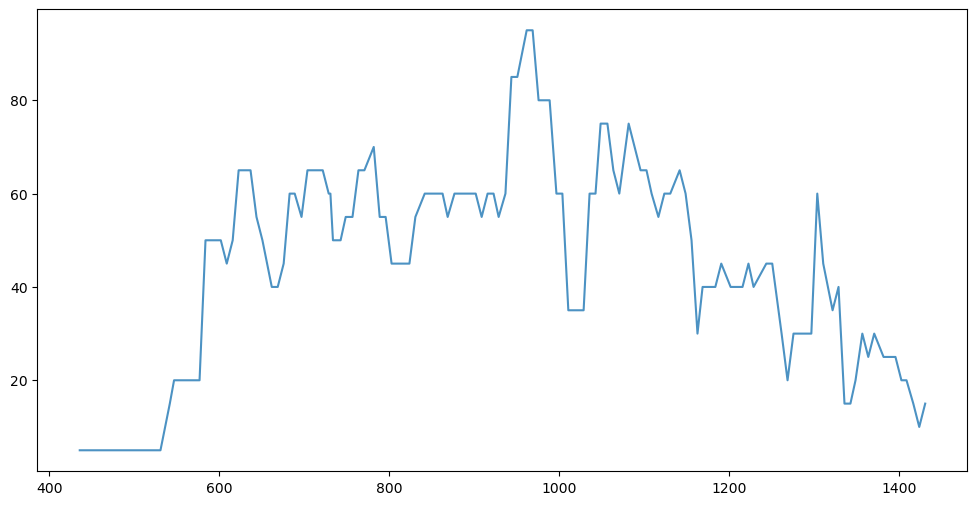

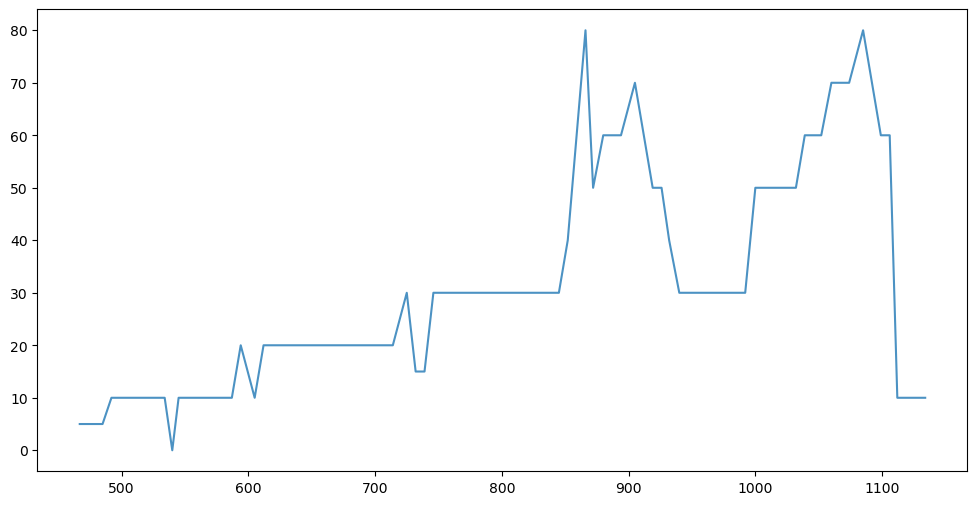

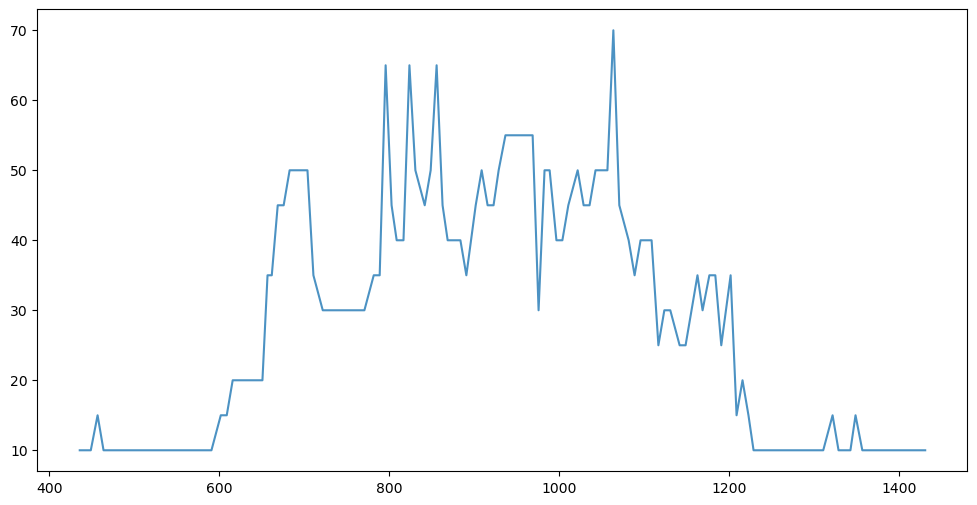

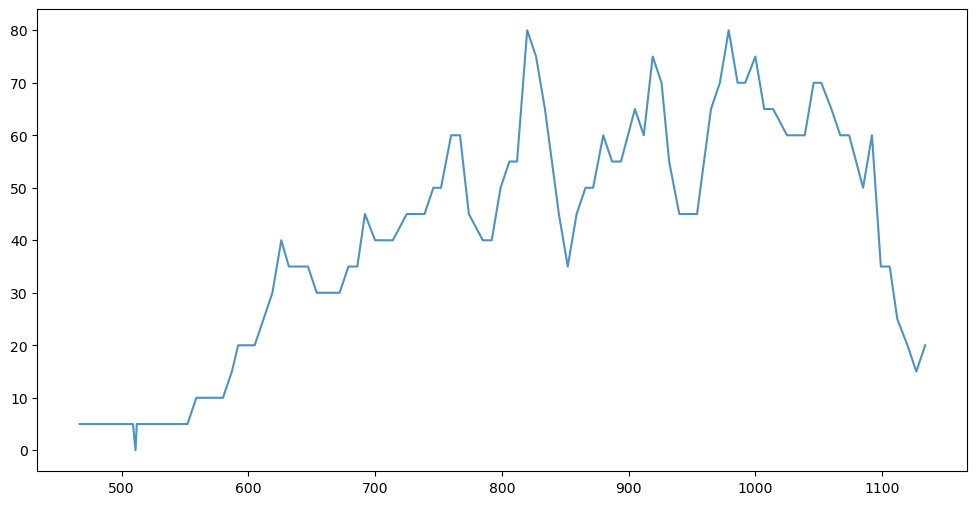

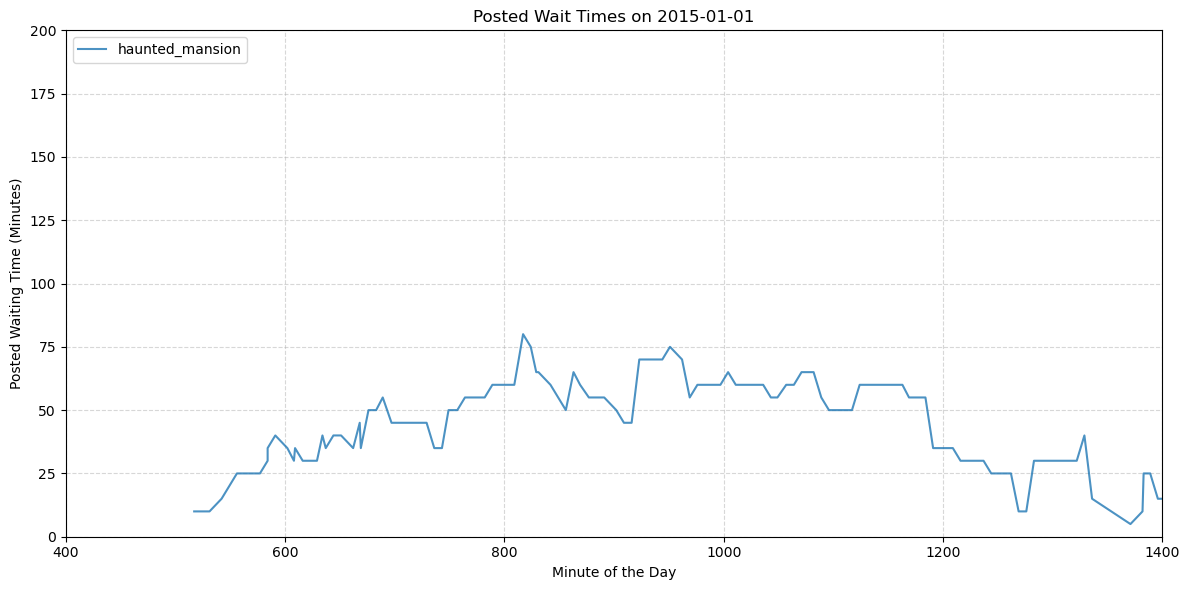

In [30]:

def plot_wait_times(input_date, attractions):
    global df_cleaned 
    # Convert input_date to datetime if it's a string
    if isinstance(input_date, str):
        date = pd.to_datetime(input_date).date()
    else:
        date = input_date
    
    # Filter data for the given date and attractions
    mask = (pd.to_datetime(df_cleaned['datetime']).dt.date == date) & (df_cleaned['attractions'].isin(attractions))
    df_filtered = df_cleaned[mask].copy()

    # Check if data exists for the given date & attractions
    if df_filtered.empty:
        print(f"No data available for {attractions} on {date}.")
        return None  # Stop execution if no data is available

    # Convert datetime to minutes since park opening
    df_filtered['minute'] = ((df_filtered['datetime'] - timedelta(hours=3)).dt.hour * 60 + 180 + df_filtered['datetime'].dt.minute)

    
    # Plot wait times for each attraction
    for attraction in attractions:
        attraction_data = df_filtered[df_filtered['attractions'] == attraction]

        # Ensure attraction has data before plotting
        if attraction_data.empty:
            print('skipping empty data')
            continue  # Skip this attraction if no data
        
        plt.figure(figsize=(12, 6))
        plt.plot(attraction_data['minute'],attraction_data['SPOSTMIN'],label=attraction,alpha=0.8)

    plt.title(f'Posted Wait Times on {date}')
    plt.xlabel('Minute of the Day')
    plt.ylabel('Posted Waiting Time (Minutes)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper left')
    plt.xticks() 
    plt.xlim(400, 1400)  
    plt.ylim(0, 200)  
    plt.tight_layout()

    return plt.gcf() 

# Example usage
sample_date = '2015-01-01'
sample_attractions = ['buzz_lightyear', 'dinosaur', 'dumbo', 'expedition_everest', 'haunted_mansion']

# Create the plot
plot_wait_times(sample_date, sample_attractions)
plt.show()


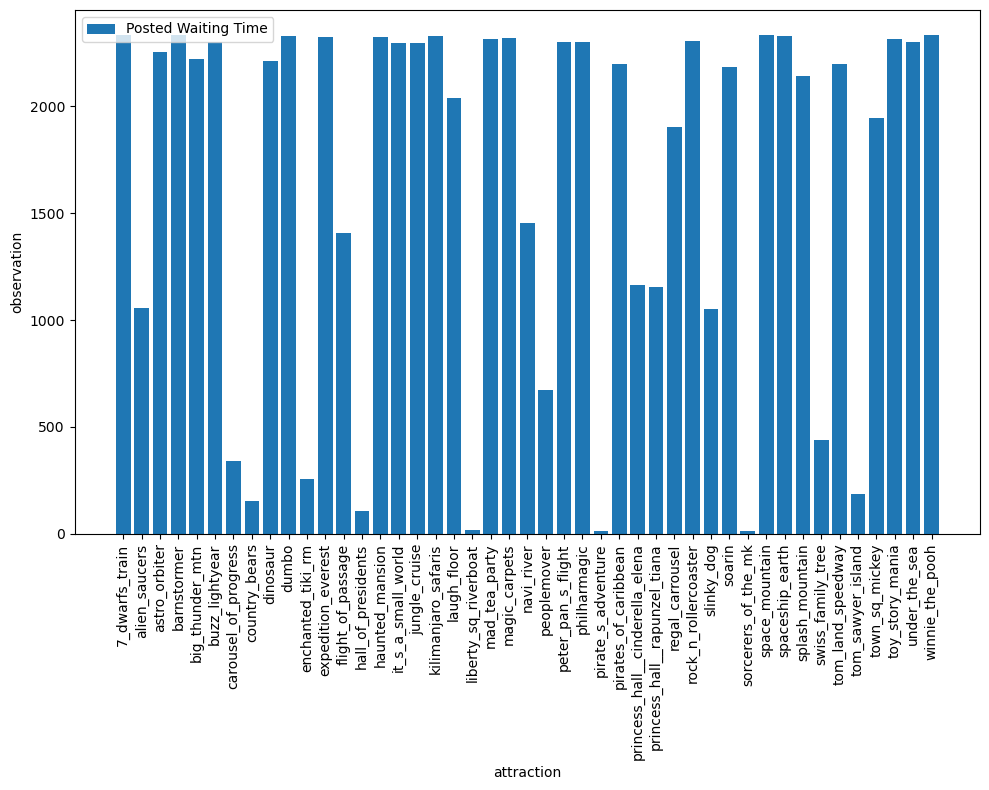

In [31]:
fig, ax = plt.subplots(figsize = (10,8))

posted_time = (df_cleaned_post.groupby(['date', 'attractions']).size().reset_index(name='observation')
        .groupby('attractions')['observation'].size())

ax.bar(posted_time.index,posted_time.values,label= 'Posted Waiting Time') 
ax.set_xlabel('attraction')
ax.set_ylabel('observation')
ax.tick_params(axis ='x',rotation=90)
ax.legend()
plt.tight_layout()
plt.show()                                       

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

actual_time = (df_cleaned_post.groupby(['date', 'attractions']).size().reset_index(name='observation')
        .groupby('attractions')['observation'].size())

ax.bar(posted_time.index,posted_time.values,label= 'Posted Waiting Time') 
ax.set_xlabel('attraction')
ax.set_ylabel('observation')
ax.tick_params(axis ='x',rotation=90)
ax.legend()
plt.tight_layout()
plt.show()                  

step 4: Study the distribution of data availability for actual waiting time information.
There seems to be not that much information on the actual waiting times at attractions. Is this because you
simply have limited data each day, or are there some days with a lot of information? Can you make some
visualizations to look into this?

<Axes: ylabel='Frequency'>

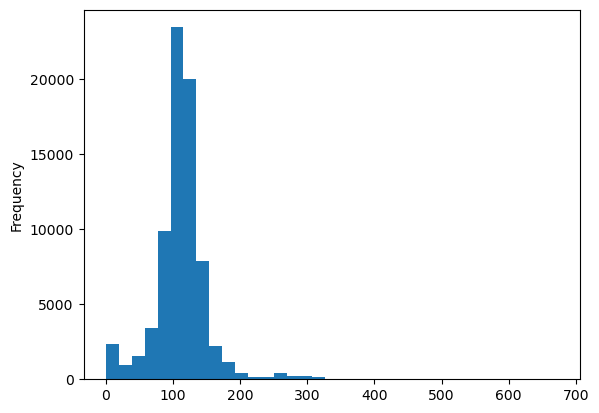

In [33]:
df_observations = (df_cleaned_act.groupby(['date', 'attractions'])
                                 .size()
                                 .reset_index(name='observations')
                                 [['observations', 'attractions', 'date']])




(df_observations['observations'].plot
                                .hist(bins = 35))

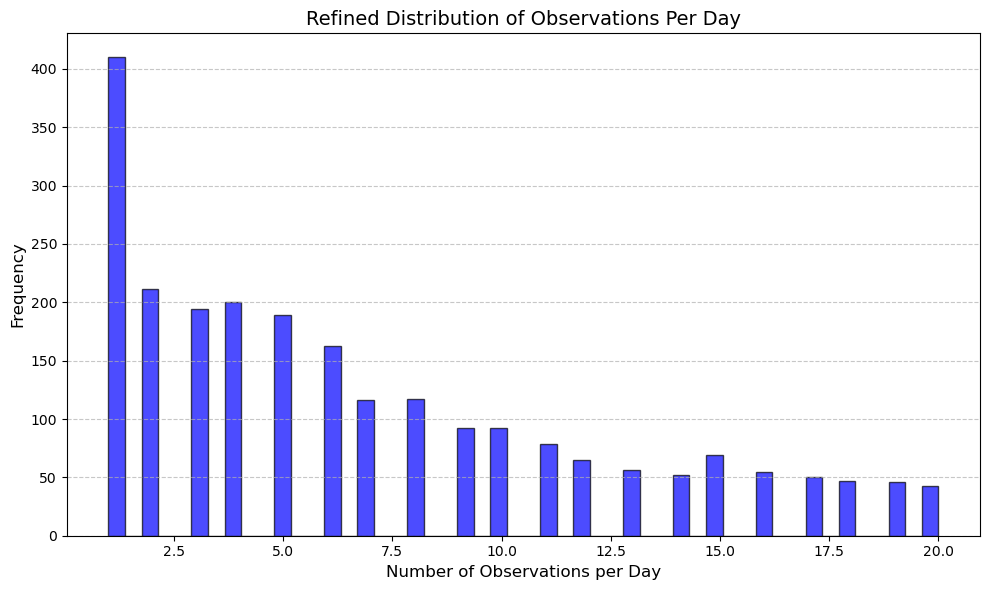

In [34]:


# **Step 1: Count Observations per Day per Attraction**
df_observations = (
    df_cleaned_act.groupby(['date', 'attractions'])  
    .size()
    .reset_index(name='observations')  
)

# **Step 2: Filter out large outliers (keep values <= 20)**
df_filtered = df_observations[df_observations['observations'] <= 20]

# **Step 3: Create Histogram**
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_filtered['observations'], bins=50, color='blue', edgecolor='black', alpha=0.7)

# **Step 4: Customize Labels**
ax.set_xlabel('Number of Observations per Day', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Refined Distribution of Observations Per Day', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#From Isabel

In [ ]:
#data cleaning

In [35]:
df_cleaned['wait_diff'] = df_cleaned['SACTMIN'] - df_cleaned['SPOSTMIN']
df_cleaned.head()

,date,datetime,SACTMIN,SPOSTMIN,attractions,wait_diff
0,2015-01-01,2015-01-01 07:51:12,24.847148,45.0,7_dwarfs_train,-20.152852
1,2015-01-01,2015-01-01 08:02:13,24.847148,60.0,7_dwarfs_train,-35.152852
3,2015-01-01,2015-01-01 08:09:12,24.847148,60.0,7_dwarfs_train,-35.152852
4,2015-01-01,2015-01-01 08:16:12,24.847148,60.0,7_dwarfs_train,-35.152852
6,2015-01-01,2015-01-01 08:23:12,24.847148,60.0,7_dwarfs_train,-35.152852


In [ ]:
groups_itp = list()

for (date, attraction), group in tqdm(df_wait.groupby(['date', 'attractions'])):
    # Time shift by 3 hours
    time_shifted = group['datetime'] - datetime.timedelta(hours=3)
    group['minute'] = 3 * 60 + time_shifted.dt.hour * 60 + time_shifted.dt.minute

    # Ensure the required columns exist before proceeding
    if not {'SACTMIN', 'SPOSTMIN'}.issubset(group.columns):
        print(f"Skipping {date} - {attraction}: Missing columns")
        continue  # Skip this iteration if columns are missing

    # Drop unnecessary columns and compute the mean for duplicate minutes
    group = group.drop(columns=['datetime', 'attraction', 'date'], errors='ignore')  # Avoid KeyError
    group = group.groupby('minute', as_index=False)[['SACTMIN', 'SPOSTMIN']].mean()

    # Define the new index (0 to 1620 minutes in 30-minute intervals)
    new_index = np.arange(0, 27 * 60 + 1, 30)

    # Set 'minute' as the index and reindex with interpolation
    group = group.set_index('minute')
    reindexed = group.reindex(np.unique(np.concatenate([new_index, group.index]))).interpolate(method='linear')

    # Keep only the required time indices
    resampled = reindexed.loc[new_index].reset_index()

    # Round to nearest 5-minute interval
    for col in ['SACTMIN', 'SPOSTMIN']:
        if col in resampled.columns:
            resampled[col] = ((resampled[col] + 2.5) // 5) * 5
    
    # Interpolate SPOSTMIN to fill blanks
    resampled['SPOSTMIN_interp'] = resampled['SPOSTMIN'].interpolate(method='linear')

    # Calculate the actual over posted ratio
    resampled['actual_over_posted'] =  resampled['SACTMIN'] / resampled['SPOSTMIN_interp']

    # Insert date and attraction columns
    resampled.insert(0, 'date', date)
    resampled.insert(1, 'attraction', attraction)

    # Append to final list
    groups_itp.append(resampled)